In [1]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models import detection
import time
from IPython.display import clear_output, display
from PIL import Image
import os

In [2]:
# Load the pre-trained car detection model
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define the Lucas-Kanade parameters for optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# def resize_image(image, max_size=640):
#     # Crop the bottom portion of the image to remove the car's hood
#     height, width = image.shape[:2]
#     image = image[int(height / 2):, :, :]

#     # Then, resize the image
#     height, width = image.shape[:2]
#     scale_factor = max_size / max(height, width)
#     if scale_factor < 1:
#         new_size = (int(width * scale_factor), int(height * scale_factor))
#         image = cv2.resize(image, new_size)

#     return image


def detect_cars(image):
    with torch.no_grad():
        transform = T.Compose([T.ToTensor()])
        input_tensor = transform(image)
        input_batch = input_tensor.unsqueeze(0)
        output = model(input_batch)
        boxes = output[0]["boxes"].numpy()
        scores = output[0]["scores"].numpy()

        # Filter boxes with a confidence score above 0.5
        # boxes = boxes[scores >= 0.6]
        valid_indices = scores >= 0.90
        boxes = boxes[valid_indices]
        scores = scores[valid_indices]

    return boxes, scores

def track_cars(prev_gray, next_gray, prev_points):
    next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, prev_points, None, **lk_params)
    status = status.ravel().astype(bool)
    moved_points = next_points[status]
    prev_points = prev_points[status]

    return prev_points, moved_points


    # calculates the optical flow between two consecutive grayscale frames prev_gray and 
    # next_gray using the Lucas-Kanade method with the given prev_points. It returns the 
    # updated positions of the points in the next frame and the positions of the points that have moved.


def process_images(image_files, output_folder):
    prev_gray = None
    prev_points = None
    moved_points = None  
    frame_counter = 0  # Added this to create unique names for each saved image


    # for img_path in image_files:
    #     image = cv2.imread(img_path)
    #     if image is None:
    #         print(f"Error loading image: {img_path}")
    #         continue

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, img_path in enumerate(image_files):
        image = cv2.imread(img_path)
        # if image is None:
        #     print(f"Error loading image: {img_path}")
        #     continue
        # image = resize_image(image)  # Add this line to resize the image

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detect cars in the current frame
        boxes, scores = detect_cars(image)
        # if len(boxes) == 0: #uncomment these 3 lines if you want it to not save image if there are no cars detected 
        #     print(f"No cars detected in image: {img_path}")
        #     continue
        curr_points = np.array([[(box[0] + box[2]) / 2, (box[1] + box[3]) / 2] for box in boxes], dtype=np.float32)

        
        # if prev_gray is not None and len(prev_points) > 0:  # Check if there are points to track
        if prev_gray is not None and prev_points is not None and len(prev_points) > 0:  # Check if there are points to track
            # Track movement of previously detected cars
            prev_points, moved_points = track_cars(prev_gray, gray, prev_points)
            movement = moved_points - prev_points

            # This part calculates the optical flow using the track_cars function and computes the movement by subtracting the previous points from the moved points.
            for i, (prev, next) in enumerate(zip(prev_points, moved_points)):
                a, b = next.ravel().astype(int)
                c, d = prev.ravel().astype(int)
                dist = np.linalg.norm(next - prev)

                # Change this threshold value to adjust the sensitivity of movement detection
                if dist > 2:
                    cv2.arrowedLine(image, (a, b), (c, d), (0, 255, 0), 2, cv2.LINE_AA)

        for (xmin, ymin, xmax, ymax), score in zip(boxes, scores):
            xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(image, f"{score:.2f}", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)


        # continue

        # Convert the image from BGR to RGB format and display it using IPython.display
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
       
         # Create a unique name for each saved image
        image_name = f"output_{frame_counter}.jpg"
        cv2.imwrite(os.path.join(output_folder, image_name), image)
        frame_counter += 1  # Increment the counter
       
        display(Image.fromarray(image))
        time.sleep(0.5)  # Wait for 500 ms before showing the next frame
        clear_output(wait=True)

        prev_gray = gray
        if len(curr_points) > 0:  # Only update prev_points if curr_points is not empty
            prev_points = curr_points.copy()
        # prev_points = curr_points.copy()

    cv2.destroyAllWindows()

/Users/junwonchoi/.local/share/virtualenvs/parked_cars_road_classification-ovyX0Fkz/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/junwonchoi/.local/share/virtualenvs/parked_cars_road_classification-ovyX0Fkz/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
#  Function to read all file names from specified folder and store in a list, with only the image name

def get_image_files(folder):
    image_files = []
    for file in os.listdir(folder):
        if file.endswith(".jpg"):
            image_files.append(os.path.join(folder, file))
    return image_files

In [17]:
test_images = get_image_files("/Volumes/JC SSD/SRILab Data/GoPro Frames")

In [18]:
output_folder = "/Volumes/JC SSD/SRILab Data/Sample Output 2"    

In [19]:
test_samples = test_images[650:800]

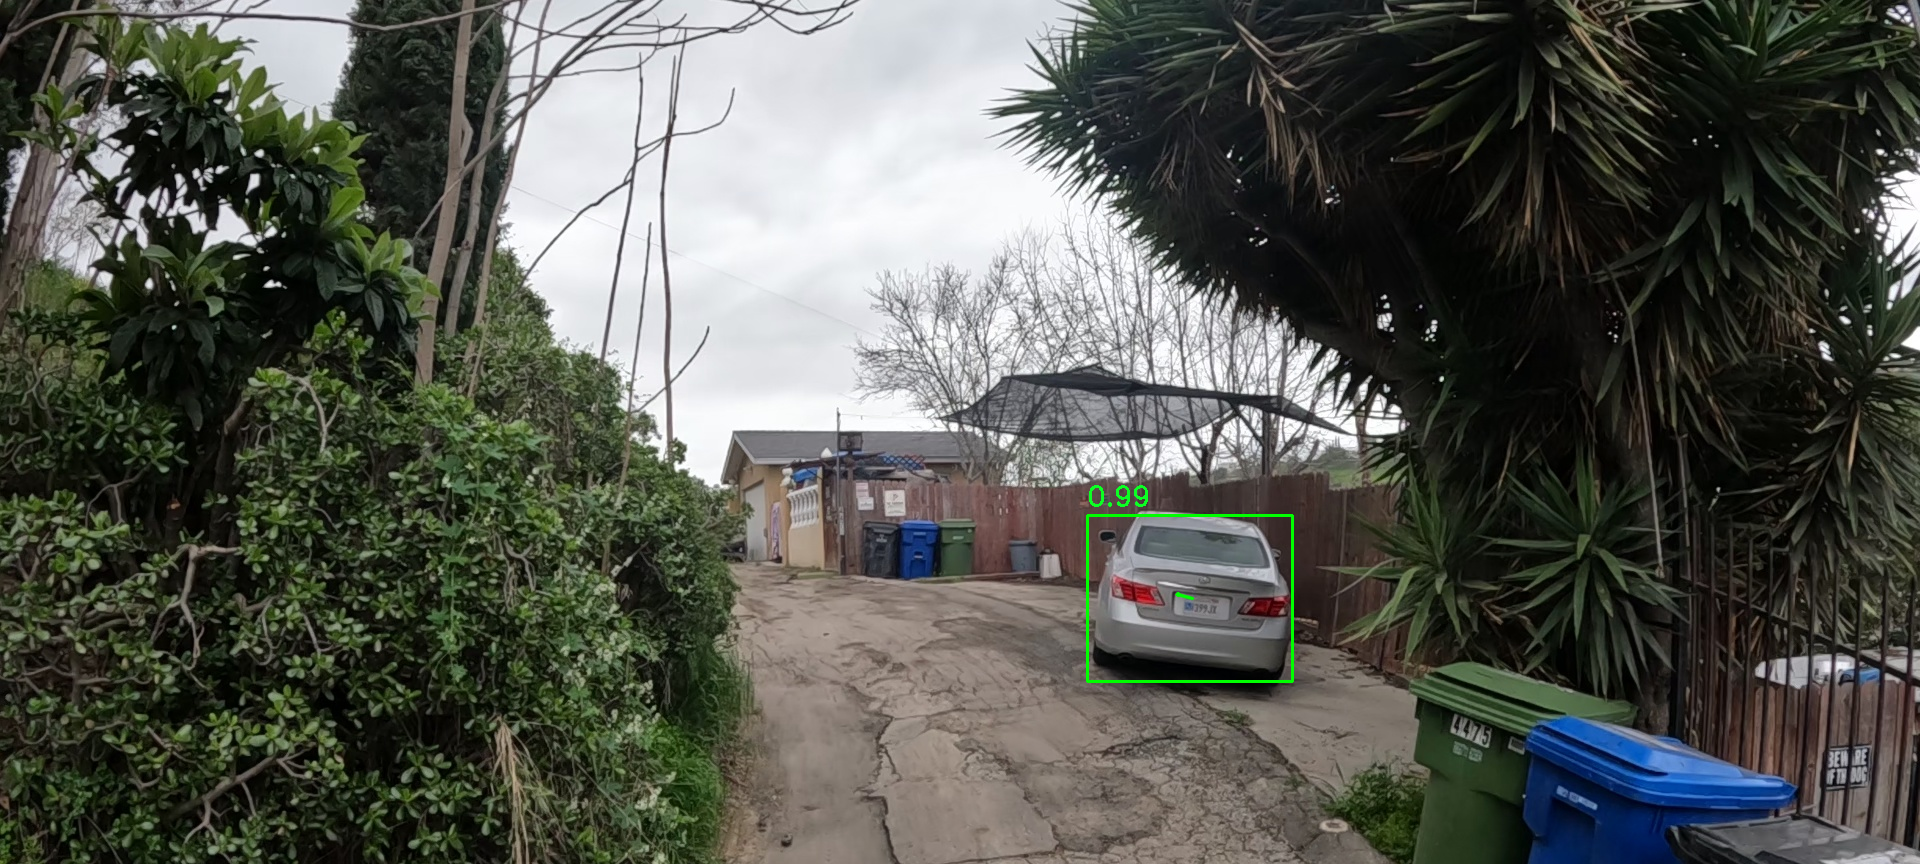

In [20]:
process_images(test_samples, output_folder)